# MNIST Addition

This example shows a simple implementation of MNIST Addition, which was first introduced in [Manhaeve et al., 2018](https://arxiv.org/abs/1805.10872). In this task, the inputs are pairs of MNIST handwritten images, and the outputs are their sums.

In Abductive Learning, we hope to first use learning part to map the input images to their digits (we call it pseudo labels), and then use reasoning part to calculate the summation of these pseudo labels to get the final result.

In [1]:
import os.path as osp

import torch
import torch.nn as nn
import matplotlib.pyplot as plt

from abl.bridge import SimpleBridge
from abl.evaluation import ReasoningMetric, SymbolMetric
from abl.learning import ABLModel, BasicNN
from abl.reasoning import KBBase, Reasoner
from abl.utils import ABLLogger, print_log
from examples.mnist_add.datasets import get_mnist_add
from examples.models.nn import LeNet5

## Load Datasets

First, we get training and testing data:

In [2]:
train_data = get_mnist_add(train=True, get_pseudo_label=True)
test_data = get_mnist_add(train=False, get_pseudo_label=True)

The datasets are illustrated as follows:

There are 30000 data examples in the training set and 5000 data examples in the test set
Each of the data example has 3 components: X, gt_pseudo_label, and Y.
As an illustration, in the First data example of the training set, we have:
X (2 images):


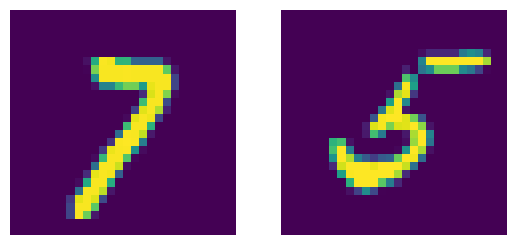

gt_pseudo_label (2 ground truth pseudo label): 7, 5
Y (their sum result): 12


In [3]:
print(f"There are {len(train_data[0])} data examples in the training set and {len(test_data[0])} data examples in the test set")
print(f"Each of the data example has {len(train_data)} components: X, gt_pseudo_label, and Y.")
print("As an illustration, in the First data example of the training set, we have:")
print(f"X ({len(train_data[0][0])} images):")
plt.subplot(1,2,1)
plt.axis('off') 
plt.imshow(train_data[0][0][0].numpy().transpose(1, 2, 0))
plt.subplot(1,2,2)
plt.axis('off') 
plt.imshow(train_data[0][0][1].numpy().transpose(1, 2, 0))
plt.show()
print(f"gt_pseudo_label ({len(train_data[1][0])} ground truth pseudo label): {train_data[1][0][0]}, {train_data[1][0][1]}")
print(f"Y (their sum result): {train_data[2][0]}")

## Learning Part

First, we build the basic learning model. We use a simple [LeNet neural network](https://en.wikipedia.org/wiki/LeNet) to complete this task.

In [4]:
cls = LeNet5(num_classes=10)
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(cls.parameters(), lr=0.001, betas=(0.9, 0.99))
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

base_model = BasicNN(
    cls,
    loss_fn,
    optimizer,
    device,
    batch_size=32,
    num_epochs=1,
)

The base model can predict the outcome class index and the probabilities for an image, as shown below:

In [5]:
pred_idx = base_model.predict(X=[torch.randn(1, 28, 28).to(device) for _ in range(32)])
print(f"Shape of pred_idx for a batch of 32 samples: {pred_idx.shape}")
pred_prob = base_model.predict_proba(X=[torch.randn(1, 28, 28).to(device) for _ in range(32)])
print(f"Shape of pred_prob for a batch of 32 samples: {pred_prob.shape}")

Shape of pred_idx for a batch of 32 samples: (32,)
Shape of pred_prob for a batch of 32 samples: (32, 10)


Then, we build an instance of `ABLModel`. The main function of `ABLModel` is to serialize data and provide a unified interface for different base machine learning models.

In [6]:
model = ABLModel(base_model)

## Logic Part

In the logic part, we first build a knowledge base.

In [7]:
# Build knowledge base and reasoner
class AddKB(KBBase):
    def __init__(self, pseudo_label_list):
        super().__init__(pseudo_label_list)

    # Implement the deduction function
    def logic_forward(self, nums):
        return sum(nums)

kb = AddKB(pseudo_label_list=list(range(10)))

The knowledge base can perform logical reasoning. Below is an example of performing (deductive) reasoning:

In [8]:
pseudo_label_sample = [1, 2]
reasoning_result = kb.logic_forward(pseudo_label_sample)
print(f"Reasoning result of pseudo label sample {pseudo_label_sample} is {reasoning_result}.")

Reasoning result of pseudo label sample [1, 2] is 3.


Then, we create a reasoner. It can help minimize inconsistencies between the knowledge base and pseudo labels predicted by the learning part.

In [9]:
reasoner = Reasoner(kb, dist_func="confidence")

## Evaluation Metrics

Set up evaluation metrics. These metrics will be used to evaluate the model performance during training and testing.

In [10]:
metric_list = [SymbolMetric(prefix="mnist_add"), ReasoningMetric(kb=kb, prefix="mnist_add")]

## Bridge Learning and Reasoning

Now, the last step is to bridge the learning and reasoning part.

In [11]:
bridge = SimpleBridge(model, reasoner, metric_list)

Perform training and testing.

In [ ]:
# Build logger
print_log("Abductive Learning on the MNIST Addition example.", logger="current")
log_dir = ABLLogger.get_current_instance().log_dir
weights_dir = osp.join(log_dir, "weights")

bridge.train(train_data, loops=5, segment_size=1/3, save_interval=1, save_dir=weights_dir)
bridge.test(test_data)